Final Project Code<br>
Name: Julian Keane<br>
PID: A14042690

(really sorry about how messy some of my code is; most of my methods are similar to those of SKLearn, and any I believe that I explained any "weird" tricks that I did. If there's anything you'd like me to clarify, feel free to email me at jekeane@ucsd.edu

In [151]:
import numpy as np
import math
from scipy import stats as stats
from matplotlib import pyplot as plt
import time
import scipy as sp
import pandas as pd
import seaborn as sns

# Classifier Superclass (Done?)

In [2]:
class Classifier(object):

    def fit(self, X_train, Y_train):
        """
        Classifier fitting function
            X_train: the features
            Y_train: the labels
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self):
        """
        Classifier prediction function; to be filled in individually for each classifier
        If the subclass has no prediction function, raise an error
        """
        raise RuntimeError("This classifier does not have a prediction function")

    def score(self, X_pred, Y_pred):
        """
        Classifier score function.
            X_pred: Feature vectors in training set
            Y_pred: Corresponding labels for X_pred
        """
        return np.mean(np.equal(self.predict(X_pred), Y_pred))

# Classifier 1 - K-Nearest Neighbors (Done, but not used due to memory inneficiency)

In [4]:
class KNNclassifier(Classifier):
    def __init__(self, k=2):
        self.k = k
        
    def predict(self, X,sparse=True):
        """
        k-NN prediction function. Adapted from code I had previously written in HW6
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        Y_pred = []
        
        #calculate distances
        if not sparse:
            distances = np.linalg.norm(self.X_train[:, np.newaxis] - X, axis = 2)
#        if sparse:
            
        #append labels to each distance
        #labels = np.tile(self.Y_train, (distances.shape[1],1)).T
        #labeled_distances = np.stack((distances,labels), axis =2)
    
        #Sort Array based on Distances and find the k closest
        sort_indexes = np.argsort(distances,axis = 0)[0:self.k].T
        for indeces in sort_indexes:
            y_vals = []
            for index in indeces:
                y_vals.append(self.Y_train[index])
            Y_pred.append(stats.mode(y_vals)[0][0])
        
        return np.array(Y_pred)

# Classifier 2 - Support Vector Machine (Done w/ linear; still need rbf implementation)

In [26]:
class SVMClassifier(Classifier):
    def __init__(self, kernel = 'linear',lmda = 5):
        valid_kernels = ['linear', 'rbf']
        if kernel not in valid_kernels:
            raise ValueError('bad kernel')
        self.kernels = kernel
        self.lmda = lmda
            
    def fit(self, X_train, Y_train, eta = 0.0000005,threshold = 0.00000001, itr = 1000):
        """
        SVM fitting function. Computes the optimal value of theta and stores it as a parameter of the object
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
            eta: learning rate. Initially set to be 0.05
            threshold: point at which the new theta and old theta differ to stop stop iteration
            itr: maximum number of iterations
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
#        f= open(filename,"w+")
        
        #initialize theta* as a random matrix
        self.theta_star = np.random.random(X_train.shape[1])
        
        def h(x,y,theta):
            """
            helper function to calculate the above h(x_i) term in the gradient
                x: the i-th vector
                y: the label of x
                theta: paramter to be optimized
            """
            #if y*x.dot(theta) >= 1:
            #    return 0
            #else:
            #    return -y*x
            
            # Create a Sparse Diagonal Matrix whose entries correspond to 1 if y*<x,theta> >=1 and 0 else
            # That sparse matrix is then used to "zero out" any vectors that have low loss value
            # That new matrix is then summed over columnwise
            S = np.abs((((np.sign(y*x.dot(theta)-1)-1)/-2)))
            S = -S*y
            S = sp.sparse.diags(S)

            return np.sum(S.dot(x),axis=0)
        
        def SVM_grad(X,Y,theta):
        #    """
        #    helper function to calculate the gradient of the SVM loss function with respect to theta
        #        X: collection of vectors
        #        Y: collection of labels
        #        theta: parameter to be optimized
        #    """
            return 2*theta + self.lmda*h(X,Y,theta)
        
        
        # Lambda function to 
        #gradient = lambda X,Y,theta: (2*theta + self.lmda*h(X,Y,theta))
        
        for i in range(itr):
            new_theta = self.theta_star - eta*SVM_grad(self.X_train, self.Y_train, self.theta_star)
#            new_theta = self.theta_star - eta*gradient(self.X_train, self.Y_train, self.theta_star)
            if np.linalg.norm(new_theta - self.theta_star, ord = 1) < threshold:
                print('broke at iteration ' + str(i))
                break
            self.theta_star = new_theta
            #normalizing theta to prevent overflow
#            self.theta_star = self.theta_star/np.linalg.norm(self.theta_star)
#        f.write("lambda = {}\neta = {}\nw = {}\ntraining accuracy is = {}\nApproximate time to run was : {}\nSize of data was {}".format(self.lmda, eta, self.theta_star,self.score(self.X_train, self.Y_train), (toc-tic), self.X_train.shape))
        
    def predict(self, X_Val):
        """
        SVM prediction function.
            X_Val: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_Val), )
        """
        Y_pred = []
        
        for x in X_Val:
            pred = 2*int((x.dot(self.theta_star)).astype(np.float64) > 0)-1
            Y_pred.append(pred)
            
        return np.array(Y_pred)
    
    def normalize_theta(self):
        self.theta_star = self.theta_star/np.linalg.norm(self.theta_star)

# Classifier 3 - Single-Layer Perceptron (Some issues still)

In [163]:
class Perceptron(Classifier):
    def __init__(self, epochs = 2):
        self.epochs = epochs
        
    def fit(self, X_train, Y_train):
        
#        f= open(filename,"w+")
        tic = time.time()
        self.X_train = X_train#np.c_[np.ones(X_train.shape[0]),X_train]
        self.Y_train = Y_train
        self.w = np.zeros(self.X_train.shape[1])
#        tuned = False
#        max_length = self.X_train.shape[0]**2
#        i = 0
        
#        while not tuned and i < max_length:
        for i in range(self.epochs):
            for x,y in zip(self.X_train, self.Y_train):
                if np.sign(x.dot(self.w)) != y:
                    new_w = self.w + 2*y*x
                    self.w = new_w
        toc = time.time()
#        f.write("epochs = {}\nw = {}\ntraining accuracy is = {}\nApproximate time to run was : {}\nSize of data was {}".format(self.epochs, self.w,self.score(self.X_train, self.Y_train), (toc-tic), self.X_train.shape))
        

    def predict(self, X_val):
        Y_pred = []
        
        for x in X_val:
            pred = 2*int((x.dot(self.w)).astype(np.float64) > 0)-1
            Y_pred.append(pred)
        return Y_pred

# Classifier 4 - Logistic Regression

In [85]:
class LogisticRegressionClassifier(Classifier):
        
    def fit(self,X_train, Y_train, n_itr = 1000, alpha = 0.05, threshold = 0.00000001):
        self.X_train = X_train
        self.Y_train = Y_train
        
        self.w = np.zeros(self.X_train.shape[1])
        
        def logistic_prob(X,Y,w):
            return 1/(1+np.exp( (sp.sparse.diags(-Y))@(X@w )))

        def logistic_loss_gradients(X,Y,w):
    
            P = logistic_prob(X, Y, w).reshape(X.shape[0],)
            w_grad = -Y@((sp.sparse.diags(1-P))@X)
    
            return w_grad
    
        for i in range(n_itr):
            new_w = self.w - alpha*logistic_loss_gradients(self.X_train,self.Y_train,self.w)
            if np.linalg.norm(new_w - self.w, ord = 1) < threshold:
                print('broke at iteration ' + str(i))
                break
            self.w = new_w

    
    def predict(self, X_val):
        Y_pred = []
        
        for x in X_val:
            pred = 2*int((x.dot(self.w)).astype(np.float64) > 0)-1
            Y_pred.append(pred)
        return Y_pred

# Parameter Tuning Functions (CV and GridSearch) (Not used due to mistakes made with writing values to files)

In [165]:
def CrossValidation(X, Y, Classifier, fold = 3):
    #split data into k partitions
    Y_fold = np.array_split(Y,fold)
    X_fold = np.array_split(X,fold)
    
    #defining accuracies before going into loop
    train_acc = []
    val_acc = []
    
    for i in range(fold):
        
        #taking one value out for validation
        indeces = list(np.linspace(0, fold-1,fold).astype(int))
        indeces.remove(i)
        X_val = X_fold[i]
        Y_val = Y_fold[i]
        
        X_train = np.vstack((x for j,x in enumerate(X_fold) if j!=i))
        Y_train = np.hstack((y for j,y in enumerate(Y_fold) if j!=i))
        
        classifier.fit(X_train, Y_train)
        train_acc.append(classifier.score(X_train, Y_train))
        val_acc.append(classifier.score(X_val, Y_val))
    
    return np.mean(train_acc), np.mean(val_acc)
    

def GridSearch(X,Y, Classifier, param_list, folds = 3):
    train_accs = []
    val_accs = []
#    np.random.seed(0)
#    np.random.shuffle(Data)
#    X = Data.T[0:len(Data.T)-2].T
#    Y = Data.T[len(Data.T)-1]
    for param in param_list:
        a,b = CrossValidation(X,Y, Classifier, par = param, fold = folds)
        train_accs.append(a)
        val_accs.append(b)
    return np.matrix(train_accs).T, np.matrix(val_accs).T


# Loading in the Data

In [33]:
# Dataset 1 - Dota 2 data from UCI ML repo
Dota_Train = np.genfromtxt('./dota2Dataset/dota2Train.csv', delimiter=',')
Dota_Test = np.genfromtxt('./dota2Dataset/dota2Test.csv', delimiter=',')

Dota = np.vstack((Dota_Train,Dota_Test))
np.random.seed(0)
np.random.shuffle(Dota)
Dota_X = Dota.T[4:].T
Dota_Y = Dota.T[0]
Ones_Dota_X = np.c_[ np.ones(Dota_X.shape[0]), Dota_X ]  

In [34]:
# Dataset 2 - Skin data from UCI ML repo
Skin = np.loadtxt('Skin_NonSkin.txt')
# Mapping labels from {1,2} (Skin, Not Skin) to {1,-1} (Skin, Not Skin)
Skin[:,3] = -2*Skin[:,3]+3

np.random.seed(0)
np.random.shuffle(Skin)
Skin_X = Skin.T[0:-1].T
Skin_Y = Skin.T[-1]
Ones_Skin_X = np.c_[ np.ones(Skin_X.shape[0]), Skin_X ]  

In [35]:
# Dataset 3 - Occupancy Data from UCI ML repo
Occupancy = np.vstack(( np.genfromtxt('datatraining.csv', delimiter = ','), np.genfromtxt('datatest2.csv', delimiter = ',') ))

#removing the one NaN value
Occupancy = pd.DataFrame(Occupancy).dropna().values
#changning labels from {0,1} to {-1,1}
Occupancy[:,5] = 2*Occupancy[:,5]-1

np.random.seed(0)
np.random.shuffle(Occupancy)
Occupancy_X = Occupancy.T[0:-1].T
Occupancy_Y = Occupancy.T[-1]
Ones_Occ_X = np.c_[ np.ones(Occupancy_X.shape[0]), Occupancy_X ] 


# Tuning hyperparameters on each dataset

In [42]:
#param list for KNN
k_list = [1,2,3,4,5]
knn_params = {"k" : k_list}

#param list for perceptron
epoch_list = [1,2,4,8,16]
perceptron_params = {"epochs" : epoch_list}

#param list for SVM
lambda_list = [1,2,3,4,5]
svm_params = {"lambda" : lambda_list}


partition = [0.8, 0.5, 0.2]
num_trials = 3

In [136]:
for epoch in epoch_list:
    for i in partition:
        X_train = Ones_Skin_X[:-int(np.rint((1-i)*Ones_Skin_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Skin_X[-int(np.rint((1-i)*Ones_Skin_X.shape[0])):,:] # Get features from test set.     
        Y_train = Skin_Y[:-int(np.rint((1-i)*Skin_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Skin_Y[-int(np.rint((1-i)*Skin_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./Perceptron/Skin/Perceptron_Skin_{}_epochs_{}{:1.1f}_trial_{}.txt".format(epoch,i,1-i,j+1)
            ptron = Perceptron(epochs = epoch)
            ptron.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("epochs = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(ptron.epochs, ptron.w,ptron.score(ptron.X_train, ptron.Y_train), ptron.score(X_test,Y_test)))
            

In [137]:
for epoch in epoch_list:
    for i in partition:
        X_train = Ones_Dota_X[:-int(np.rint((1-i)*Ones_Dota_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Dota_X[-int(np.rint((1-i)*Ones_Dota_X.shape[0])):,:] # Get features from test set.     
        Y_train = Dota_Y[:-int(np.rint((1-i)*Dota_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Dota_Y[-int(np.rint((1-i)*Dota_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./Perceptron/Dota/Perceptron_Dota_{}_epochs_{}{:1.1f}_trial_{}.txt".format(epoch,i,1-i,j+1)
            ptron = Perceptron(epochs = epoch)
            ptron.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("epochs = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(ptron.epochs, ptron.w,ptron.score(ptron.X_train, ptron.Y_train), ptron.score(X_test,Y_test)))
            

In [138]:
for epoch in epoch_list:
    for i in partition:
        X_train = Ones_Occ_X[:-int(np.rint((1-i)*Ones_Occ_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Occ_X[-int(np.rint((1-i)*Ones_Occ_X.shape[0])):,:] # Get features from test set.     
        Y_train = Occupancy_Y[:-int(np.rint((1-i)*Occupancy_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Occupancy_Y[-int(np.rint((1-i)*Occupancy_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./Perceptron/Occ/Perceptron_Dota_{}_epochs_{}{:1.1f}_trial_{}.txt".format(epoch,i,1-i,j+1)
            ptron = Perceptron(epochs = epoch)
            ptron.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("epochs = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(ptron.epochs, ptron.w,ptron.score(ptron.X_train, ptron.Y_train), ptron.score(X_test,Y_test)))
            

In [45]:
for lmda in lambda_list:
    for i in partition:
        X_train = Ones_Skin_X[:-int(np.rint((1-i)*Ones_Skin_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Skin_X[-int(np.rint((1-i)*Ones_Skin_X.shape[0])):,:] # Get features from test set.     
        Y_train = Skin_Y[:-int(np.rint((1-i)*Skin_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Skin_Y[-int(np.rint((1-i)*Skin_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./SVM/Skin/SVM_Skin_{}_lambda_{}{:1.1f}_trial_{}.txt".format(lmda,i,1-i,j+1)
            svm = SVMClassifier(lmda = lmda)
            svm.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("lmda = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(svm.lmda, svm.theta_star,svm.score(svm.X_train, svm.Y_train), svm.score(X_test,Y_test)))
            

In [44]:
for lmda in lambda_list:
    for i in partition:
        X_train = Ones_Dota_X[:-int(np.rint((1-i)*Ones_Dota_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Dota_X[-int(np.rint((1-i)*Ones_Dota_X.shape[0])):,:] # Get features from test set.     
        Y_train = Dota_Y[:-int(np.rint((1-i)*Dota_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Dota_Y[-int(np.rint((1-i)*Dota_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./SVM/Dota/SVM_Dota_{}_lambda_{}{:1.1f}_trial_{}.txt".format(lmda,i,1-i,j+1)
            svm = SVMClassifier(lmda = lmda)
            svm.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("lmda = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(svm.lmda, svm.theta_star,svm.score(svm.X_train, svm.Y_train), svm.score(X_test,Y_test)))
            

In [43]:
for lmda in lambda_list:
    for i in partition:
        X_train = Ones_Occ_X[:-int(np.rint((1-i)*Ones_Occ_X.shape[0])),:] # Get features from train + val set.
        X_test  = Ones_Occ_X[-int(np.rint((1-i)*Ones_Occ_X.shape[0])):,:] # Get features from test set.     
        Y_train = Occupancy_Y[:-int(np.rint((1-i)*Occupancy_Y.shape[0]))] # Get labels from train + val set.
        Y_test  = Occupancy_Y[-int(np.rint((1-i)*Occupancy_Y.shape[0])):] # Get labels from test set.  
        for j in range(num_trials):
            filename = "./SVM/Occ/SVM_Occ_{}_lambda_{}{:1.1f}_trial_{}.txt".format(lmda,i,1-i,j+1)
            svm = SVMClassifier(lmda = lmda)
            svm.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("lmda = {}\nw = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(svm.lmda, svm.theta_star,svm.score(svm.X_train, svm.Y_train), svm.score(X_test,Y_test)))
            

In [93]:
for i in partition:
    X_train = Ones_Dota_X[:-int(np.rint((1-i)*Ones_Dota_X.shape[0])),:] # Get features from train + val set.
    X_test  = Ones_Dota_X[-int(np.rint((1-i)*Ones_Dota_X.shape[0])):,:] # Get features from test set.     
    Y_train = Dota_Y[:-int(np.rint((1-i)*Dota_Y.shape[0]))] # Get labels from train + val set.
    Y_test  = Dota_Y[-int(np.rint((1-i)*Dota_Y.shape[0])):] # Get labels from test set.  
    for j in range(num_trials):
            filename = "./LogReg/Dota/LR_Dota_{}_{:1.1f}_trial_{}.txt".format(i,1-i,j+1)
            LR = LogisticRegressionClassifier()
            LR.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("w = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(LR.w,LR.score(LR.X_train, LR.Y_train), LR.score(X_test,Y_test)))

/Users/juliankeane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [92]:
for i in partition:
    X_train = Ones_Skin_X[:-int(np.rint((1-i)*Ones_Skin_X.shape[0])),:] # Get features from train + val set.
    X_test  = Ones_Skin_X[-int(np.rint((1-i)*Ones_Skin_X.shape[0])):,:] # Get features from test set.     
    Y_train = Skin_Y[:-int(np.rint((1-i)*Skin_Y.shape[0]))] # Get labels from train + val set.
    Y_test  = Skin_Y[-int(np.rint((1-i)*Skin_Y.shape[0])):] # Get labels from test set.  
    for j in range(num_trials):
            filename = "./LogReg/Skin/LR_Skin_{}_{:1.1f}_trial_{}.txt".format(i,1-i,j+1)
            LR = LogisticRegressionClassifier()
            LR.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("w = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(LR.w,LR.score(LR.X_train, LR.Y_train), LR.score(X_test,Y_test)))

/Users/juliankeane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [91]:
for i in partition:
    X_train = Ones_Occ_X[:-int(np.rint((1-i)*Ones_Occ_X.shape[0])),:] # Get features from train + val set.
    X_test  = Ones_Occ_X[-int(np.rint((1-i)*Ones_Occ_X.shape[0])):,:] # Get features from test set.     
    Y_train = Occupancy_Y[:-int(np.rint((1-i)*Occupancy_Y.shape[0]))] # Get labels from train + val set.
    Y_test  = Occupancy_Y[-int(np.rint((1-i)*Occupancy_Y.shape[0])):] # Get labels from test set.  
    for j in range(num_trials):
            filename = "./LogReg/Occ/LR_Occ_{}_{:1.1f}_trial_{}.txt".format(i,1-i,j+1)
            LR = LogisticRegressionClassifier()
            LR.fit(X_train,Y_train)
            f= open(filename,"w+")
            f.write("w = {}\ntraining accuracy is = {}\ntesting accuracy is {}".format(LR.w,LR.score(LR.X_train, LR.Y_train), LR.score(X_test,Y_test)))

/Users/juliankeane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


# Looking at Highest Accuracies

### Due to worries about training time, I outputted all the accuracies to many text files instead of using the Cross-Validation function above. I will attach the text files in an organized format in a zip file with this submission, but the values used from here are hard-coded from those results. In the future, I would have changed how I generated my text file 

In [165]:
#Dota - SVMs


SVM_Dota_20_test_acc = np.array((
                                  [0.5289417764555886+0.536810151174792+0.528541072187481],
                                  [0.5600388561714529+0.5536640155424686+0.5441563960900977],
                                  [0.5701293181956165+0.569740756481088+0.5685265011231863],
                                  [0.5753749013417522+0.5784469673972437+0.5768441503248133],
                                  [0.5809969036488374+0.5863153421164471+0.5822111590067391]
                                 ))/3


SVM_Dota_50_test_acc = np.array((
                                  [0.5648702207025179+0.5569241529375194+0.5653364936276034],
                                  [0.5849005284426484+0.581889182468138+0.5842205470935654],
                                  [0.5910397886229406+0.5936431457880013+0.5891941249611439],
                                  [0.5912146409698477+0.5939345663661797+0.5924774634752875],
                                  [0.5955859496425241+0.593701429903637+0.5943231271370842]
                                 ))/3



SVM_Dota_80_test_acc = np.array((
                                  [0.5857011025304775+0.5834668998008645+0.580407013453786],
                                  [0.5946864830734858+0.5964349895575307+0.5917237359755209],
                                  [0.598814901160814+0.5995920151537228+0.5984749137889164],
                                  [0.5994463062800525+0.5986691922871437+0.5992034581572685],
                                  [0.5987663315362572+0.5999805721501773+0.6007091165185293]
                                 ))/3

In [166]:
#Dota - Perceptrons

Per_Dota_20_test_acc = np.array((
                                  [0.5384858235686965],
                                  [0.5389108129439621],
                                  [0.5393722299799648],
                                  [0.5426628619998786],
                                  [0.5365308724424747]
                                 ))


Per_Dota_50_test_acc = np.array((
                                  [0.5253924463786136],
                                  [0.5294529064345663],
                                  [0.524149051911719],
                                  [0.5272381100404103],
                                  [0.5246736089524402]
                                 ))


Per_Dota_80_test_acc = np.array((
                                  [0.5307688571567342],
                                  [0.521734906989169],
                                  [0.5256204769537132],
                                  [0.5189178687648744],
                                  [0.5146437418038758]
                                 ))

In [167]:
#Dota - Logistic Regression
LR_Dota_80_train_acc = 0.5163985186084633
LR_Dota_80_test_acc = 0.5154694254213414

LR_Dota_50_train_acc = 0.5186703450419645
LR_Dota_50_test_acc = 0.5133082064034815

LR_Dota_20_train_acc = 0.5235805527223275
LR_Dota_20_test_acc = 0.5165563718049906

In [168]:
#Skin - SVM
SVM_Skin_20_test_acc = np.array((
                                  [0.878191852932475+0.9045173071626047+0.8113656998867612],
                                  [0.8562582251104333+0.8755904226559073+0.8130948858941269],
                                  [0.9024769696907868+0.7667129143160278+0.911469757097824],
                                  [0.8604154127092621+0.9282974403966416+0.8421747957112107],
                                  [0.9308478622364139+0.8694133009599788+0.9013088764881712]
                                 ))/3




SVM_Skin_50_test_acc = np.array((
                                  [0.7803767302167668+0.9047564638286759+0.4631512797074954],
                                  [0.928449007573779+0.8250032645599373+0.9227523504831548],
                                  [0.7832903499608252+0.41385642465395667+0.9177820579785845],
                                  [0.6574334029772787+0.8123449334029773+0.8774810655523635],
                                  [0.7804012144162967+0.8720945416557848+0.39129015408722906]
                                 ))/3



SVM_Skin_80_test_acc = np.array((
                                  [0.930913468405052+0.8586847850482545+0.4701393564709963],
                                  [0.7810899593968701+0.8599906143518802+0.8668258146130461],
                                  [0.903511456611781+0.9283222133806697+0.9037358960233417],
                                  [0.8272428638468915+0.9056946399787803+0.9301993430046316],
                                  [0.8791087715002754+0.9275468772316419+0.8136336740731672]
                                 ))/3

In [169]:
#Skin - Perceptron 


Per_Skin_20_test_acc = np.array((
                                  [0.8326770247798986],
                                  [0.7943696887465187],
                                  [0.8151352233659447],
                                  [0.7878100037746243],
                                  [0.7886975505748651]
                                 ))



Per_Skin_50_test_acc = np.array((
                                  [0.9318849569078088],
                                  [0.9113753591015931],
                                  [0.7678816270566727],
                                  [0.780466505615043],
                                  [0.7733171193523113]
                                 ))



Per_Skin_80_test_acc = np.array((
                                  [0.7858848013711208],
                                  [0.791291750831446],
                                  [0.7895778498704372],
                                  [0.793046458958193],
                                  [0.7891289710473159]
                                 ))

In [170]:
#Skin - Logistic Regression
LR_Skin_80_train_acc = 0.48033114677167604
LR_Skin_80_test_acc = 0.4841362143192345

LR_Skin_50_train_acc = 0.8611512376661852
LR_Skin_50_test_acc = 0.8595586314964743

LR_Skin_20_train_acc = 0.8658464426353267
LR_Skin_20_test_acc = 0.8679085520745131

In [171]:
#Occupancy - SVM


SVM_Occ_20_test_acc = np.array((
                                  [0.9599050013970383+0.950544844928751+0.9307069013690975],
                                  [0.9465632858340318+0.9606733724504052+0.9513830678960603],
                                  [0.9405560212349818+0.9592064822576138+0.9605336686225202],
                                  [0.9549455155071249+0.9466331377479743+0.9626292260407935],
                                  [0.9603939647946353+0.9545962559374127+0.9568315171835708]
                                 ))/3



SVM_Occ_50_test_acc = np.array((
                                  [0.9503799731783639+0.9566383549396513+0.8183951721054984],
                                  [0.9221054984354046+0.9594322753687975+0.9623379526151096],
                                  [0.9599910594546267+0.9545149754135003+0.9509387572641931],
                                  [0.8217478766204739+0.9121591417076441+0.20987930263746088],
                                  [0.9516092981671882+0.8761734465802414+0.9540679481448369]
                                 ))/3



SVM_Occ_80_test_acc = np.array((
                                  [0.9600447052249231+0.9547359597652976+0.9575300363229953],
                                  [0.9561329980441464+0.9555741827326069+0.9592064822576138],
                                  [0.9558535903883767+0.9592064822576138+0.9558535903883767],
                                  [0.9516624755518301+0.9580888516345348+0.9597652975691534],
                                  [0.8038558256496228+0.9527801061749092+0.9547359597652976]
                                 ))/3

In [172]:
#Occupancy - Per


Per_Occ_20_test_acc = np.array((
                                  [0.9413243922883487],
                                  [0.9467728415758592],
                                  [0.9583682592903046],
                                  [0.9711511595417714],
                                  [0.9865185806091087]
                                 ))



Per_Occ_50_test_acc = np.array((
                                  [0.9504917299955298],
                                  [0.9611086276262852],
                                  [0.9684845775592311],
                                  [0.9754135002235136],
                                  [0.9797720160929817]
                                 ))



Per_Occ_80_test_acc = np.array((
                                  [0.9508242525845209],
                                  [0.9547359597652976],
                                  [0.9659122659960883],
                                  [0.9784856105057279],
                                  [0.980720871751886]
                                 ))

In [173]:
#Occupancy - Logistic Regression
LR_Occ_80_train_acc = 0.9548756635931824
LR_Occ_80_test_acc = 0.9558535903883767

LR_Occ_50_train_acc = 0.949144964792668
LR_Occ_50_test_acc = 0.9501564595440322

LR_Occ_20_train_acc = 0.9511036602402906
LR_OC_20_test_acc = 0.961441743503772

In [149]:
def draw_heatmap_SVM(acc, param_list):
    '''
    Slightly modifying some code provided by the instructional team for HW5 (original = draw_heatmap_linear)
    '''
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$\lambda$')
    plt.title("training accuracy w.r.t. $\lambda$")
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
def draw_heatmap_Per(acc, param_list):
    '''
    Slightly modifying some code provided by the instructional team for HW5 (original = draw_heatmap_linear)
    '''
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='Epochs')
    plt.title('training accuracy w.r.t. number of epochs')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

Occ


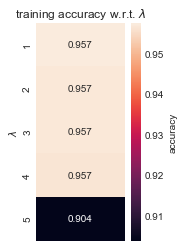

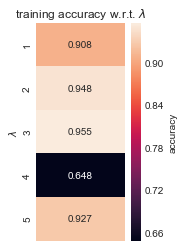

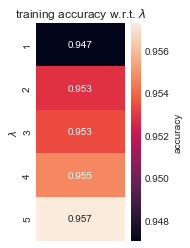

Skin


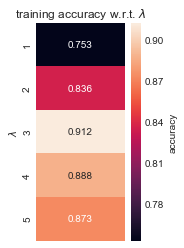

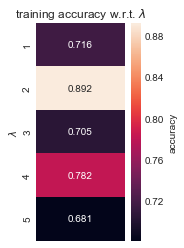

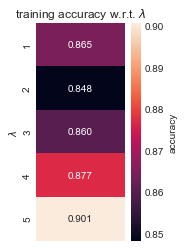

Dota


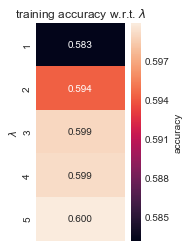

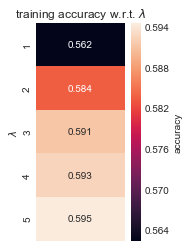

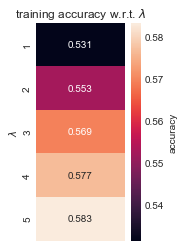

In [160]:
print("Occ")
draw_heatmap_SVM(SVM_Occ_80_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Occ_50_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Occ_20_test_acc,lambda_list)
print("Skin")
draw_heatmap_SVM(SVM_Skin_80_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Skin_50_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Skin_20_test_acc,lambda_list)
print("Dota")
draw_heatmap_SVM(SVM_Dota_80_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Dota_50_test_acc,lambda_list)
draw_heatmap_SVM(SVM_Dota_20_test_acc,lambda_list)

Occ


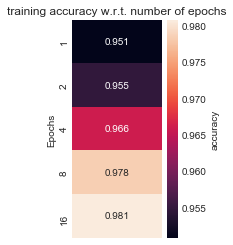

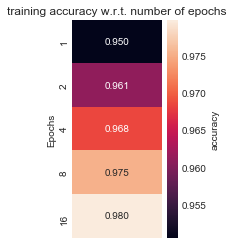

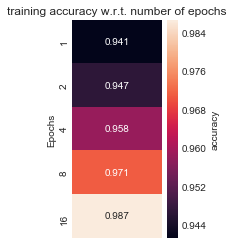

Skin


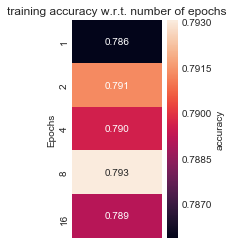

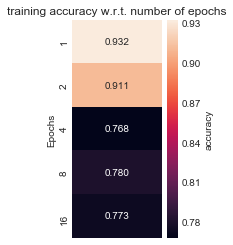

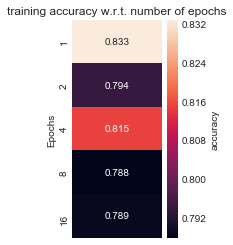

Dota


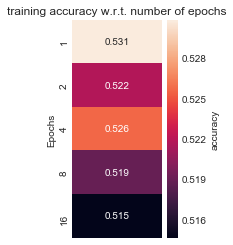

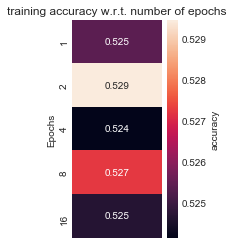

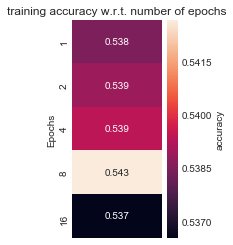

In [174]:
print("Occ")
draw_heatmap_Per(Per_Occ_80_test_acc,epoch_list)
draw_heatmap_Per(Per_Occ_50_test_acc,epoch_list)
draw_heatmap_Per(Per_Occ_20_test_acc,epoch_list)
print("Skin")
draw_heatmap_Per(Per_Skin_80_test_acc,epoch_list)
draw_heatmap_Per(Per_Skin_50_test_acc,epoch_list)
draw_heatmap_Per(Per_Skin_20_test_acc,epoch_list)
print("Dota")
draw_heatmap_Per(Per_Dota_80_test_acc,epoch_list)
draw_heatmap_Per(Per_Dota_50_test_acc,epoch_list)
draw_heatmap_Per(Per_Dota_20_test_acc,epoch_list)